In [1]:
import pandas as pd
import librosa
import pickle
import librosa
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [60]:
# #To remove Output files
# import shutil
# shutil.rmtree('/kaggle/working/tune_dir')


In [2]:
labeled_audio = '/kaggle/working/label_enc_audio_975.pkl'

In [3]:
def load_audio_files(file_name):
  labeled_audio_array = []

  df = pd.read_csv('/kaggle/input/975-lung-sound-files/' + file_name)
  audio_file_path = '/kaggle/input/975-lung-sound-files/Audio/'

  for index, row in df.iterrows():
    fileName = row['FileName']
    _audio_path = audio_file_path + str(fileName) + ".wav"
    _label = row['Label']

    y, sr = librosa.load(_audio_path, sr=22500, duration=6)

    labeled_audio_array.append([y,_label])

  return labeled_audio_array

In [4]:
labeled_audio_array = load_audio_files("MetaData.csv")

In [5]:
with open(labeled_audio, "wb") as file:
    pickle.dump(labeled_audio_array, file)

print(f"Array serialized and saved to '{labeled_audio}'.")

Array serialized and saved to '/kaggle/working/label_enc_audio_975.pkl'.


In [6]:
def read_serialized_file(file_name):
  directory = '/kaggle/working/' + file_name # Change 'directory' Accordingly
  infile = open(directory,'rb')
  loaded_data = pickle.load(infile)
  infile.close()
  return loaded_data

In [7]:
def generate_mel_spec(audio):
  mel = librosa.power_to_db(librosa.feature.melspectrogram(y=audio, sr=22050, n_mels=128, n_fft=2048, hop_length=512))
  return mel

def generate_mfcc(audio):
  mfcc = librosa.feature.mfcc(y=audio, n_mfcc=128, n_fft=2048, hop_length=512)
  return mfcc

def generate_chroma(audio):
  chroma = librosa.feature.chroma_stft(y=audio, sr=22050, n_chroma=128, n_fft=2048, hop_length=512)
  return chroma

In [8]:
def create_features():
  labelled_features = []

  audio_array = read_serialized_file("label_enc_audio_975.pkl")

  for raw_audio, label in audio_array:
    melsp = generate_mel_spec(raw_audio)
    mfcc = generate_mfcc(raw_audio)
    chroma = generate_chroma(raw_audio)

    three_chanel = np.stack((melsp, mfcc, chroma), axis=2)

    labelled_features.append([three_chanel, label])

  print(len(labelled_features))

  return labelled_features


In [9]:
stacked_labeled_features = create_features()

stacked_features_path = '/kaggle/working/stacked_specs_975.pkl'

/opt/conda/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


975


In [10]:
with open(stacked_features_path, "wb") as file:
    pickle.dump(stacked_labeled_features, file)

In [11]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten,  BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

from sklearn.utils import shuffle
from keras import callbacks
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [12]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics = ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color='orange', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      ylim_max = 1.05  # Adjust the padding value as needed
      plt.ylim([0, ylim_max])
      y_ticks = np.arange(0, ylim_max, 0.2)  # Define y-axis ticks with 0.1 increments
      plt.yticks(y_ticks)
    plt.grid(linestyle='--', linewidth=0.5, color='gray')
    plt.legend()

In [13]:
stacked_spects = read_serialized_file("stacked_specs_975.pkl")

In [14]:
feature_data = pd.DataFrame(stacked_spects,columns=['feature','class'])

In [15]:
X = np.array(feature_data['feature'].tolist())
y = np.array(feature_data['class'].tolist())

In [16]:
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.3,random_state=0, stratify=y)

X_test, X_validate, y_test, y_validate = train_test_split(X_,y_,test_size=0.5,random_state=0, stratify=y_)

In [17]:
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(X_validate))

(682, 128, 264, 3)
(146, 128, 264, 3)
(147, 128, 264, 3)


In [18]:
input_shape = (128, 264, 3)

In [55]:
# Up to now, best model 89% accuracy on test set. Can change while reproducing due to dropout etc.
# 494,505 params

model_holdout = Sequential()

model_holdout.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
model_holdout.add(MaxPooling2D((2, 2)))
model_holdout.add(BatchNormalization())

model_holdout.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model_holdout.add(MaxPooling2D((2, 2)))
model_holdout.add(BatchNormalization())

model_holdout.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_holdout.add(MaxPooling2D((2, 2)))
model_holdout.add(BatchNormalization())

model_holdout.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_holdout.add(MaxPooling2D((2, 2)))
model_holdout.add(BatchNormalization())

model_holdout.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_holdout.add(MaxPooling2D((2, 2)))
model_holdout.add(BatchNormalization())

model_holdout.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_holdout.add(MaxPooling2D((2, 2)))
model_holdout.add(BatchNormalization())

model_holdout.add(Conv2D(128, (3, 3), padding='same', activation='relu'))

model_holdout.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model_holdout.add(Dropout(0.25))

model_holdout.add(GlobalAveragePooling2D())

model_holdout.add(Dense(9, activation='softmax'))
model_holdout.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [56]:
# model_holdout = Sequential()

# model_holdout.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
# model_holdout.add(MaxPooling2D((2, 2)))
# model_holdout.add(BatchNormalization())

# model_holdout.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
# model_holdout.add(MaxPooling2D((2, 2)))
# model_holdout.add(BatchNormalization())
# # model_holdout.add(Dropout(0.25))

# model_holdout.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
# model_holdout.add(MaxPooling2D((2, 2)))
# model_holdout.add(BatchNormalization())

# model_holdout.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
# model_holdout.add(MaxPooling2D((2, 2)))
# model_holdout.add(BatchNormalization())
# # model_holdout.add(Dropout(0.25))

# model_holdout.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
# model_holdout.add(MaxPooling2D((2, 2)))
# model_holdout.add(BatchNormalization())

# model_holdout.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
# model_holdout.add(MaxPooling2D((2, 2)))
# model_holdout.add(BatchNormalization())
# # model_holdout.add(Dropout(0.25))

# model_holdout.add(Conv2D(128, (3, 3), padding='same', activation='relu'))

# model_holdout.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
# model_holdout.add(Dropout(0.25))

# model_holdout.add(GlobalAveragePooling2D())
# model_holdout.add(Flatten())

# model_holdout.add(Dense(128, activation='relu')

# model_holdout.add(Dense(9, activation='softmax'))
# model_holdout.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [57]:
model_holdout.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 128, 264, 32)      896       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 64, 132, 32)      0         
 g2D)                                                            
                                                                 
 batch_normalization_36 (Bat  (None, 64, 132, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_49 (Conv2D)          (None, 64, 132, 32)       9248      
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 32, 66, 32)       0         
 g2D)                                                            
                                                      

In [58]:
earlystopping = callbacks.EarlyStopping(monitor ="val_accuracy", mode ="max", patience = 20, restore_best_weights = True, verbose=1)

baseline_history = model_holdout.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_validate, y_validate), callbacks =[earlystopping])

Epoch 1/100


2023-10-06 14:51:46.680711: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


22/22 [==============================] - 6s 52ms/step - loss: 2.0024 - accuracy: 0.3402 - val_loss: 2.4426 - val_accuracy: 0.1293
Epoch 2/100
22/22 [==============================] - 1s 34ms/step - loss: 1.6696 - accuracy: 0.4765 - val_loss: 2.3968 - val_accuracy: 0.2245
Epoch 3/100
22/22 [==============================] - 1s 37ms/step - loss: 1.3867 - accuracy: 0.5425 - val_loss: 2.2246 - val_accuracy: 0.2517
Epoch 4/100
22/22 [==============================] - 1s 44ms/step - loss: 1.1661 - accuracy: 0.6144 - val_loss: 2.0146 - val_accuracy: 0.3878
Epoch 5/100
22/22 [==============================] - 1s 35ms/step - loss: 1.0278 - accuracy: 0.6466 - val_loss: 1.8464 - val_accuracy: 0.4082
Epoch 6/100
22/22 [==============================] - 1s 34ms/step - loss: 0.8614 - accuracy: 0.7258 - val_loss: 1.6545 - val_accuracy: 0.4694
Epoch 7/100
22/22 [==============================] - 1s 34ms/step - loss: 0.7354 - accuracy: 0.7771 - val_loss: 1.4711 - val_accuracy: 0.4762
Epoch 8/100
22/22 

In [59]:
print(model_holdout.evaluate(x=X_test,y=y_test))

5/5 [==============================] - 0s 9ms/step - loss: 0.3253 - accuracy: 0.8973
[0.32533764839172363, 0.8972602486610413]


In [127]:
# model_holdout.save('model_v1')

In [63]:
# Save the Modle to file in the current working directory

Pkl_Filename = "model_v2_89.72.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model_holdout, file)

In [64]:
# Load the Model back from file
# Pkl_Filename = "model_v1_84.9.pkl"
with open(Pkl_Filename, 'rb') as file:  
    Pickled_LR_Model = pickle.load(file)

Pickled_LR_Model

In [62]:
print(Pickled_LR_Model.evaluate(x=X_test,y=y_test))

5/5 [==============================] - 0s 9ms/step - loss: 0.3253 - accuracy: 0.8973
[0.32533764839172363, 0.8972602486610413]


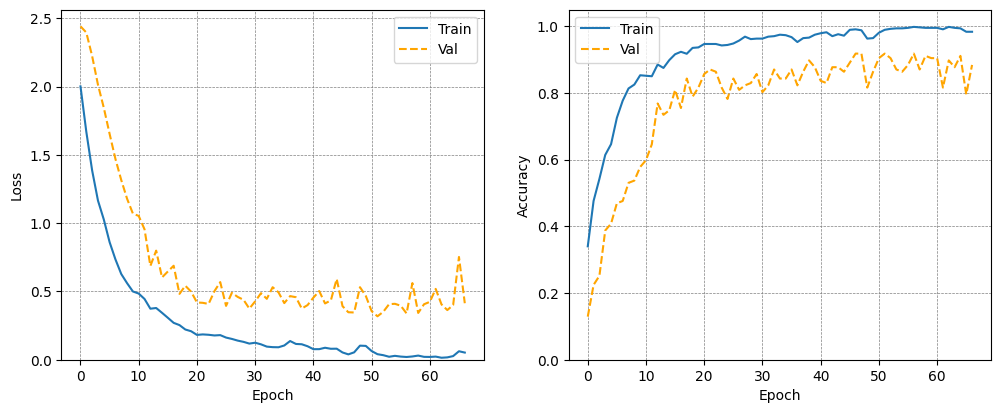

In [65]:
plot_metrics(baseline_history)

In [ ]:
a = y_test

b = model.predict(X_test)

actual = a #np.argmax(a, axis=1)
predicted = np.argmax(b, axis=1)
# print(predicted)

confusion_matrix = metrics.confusion_matrix(actual, predicted)

plt.figure(figsize=(6,4))
fx=sns.heatmap(confusion_matrix, annot=True,cmap="Blues")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
plt.show()

# **Hyper Parameter tuning**


In [62]:
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam

In [46]:
# def build_model(hp):
#     model = Sequential()

#     model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(BatchNormalization())

#     model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(BatchNormalization())
#     model.add(Dropout(hp.Choice('dropout2', values=[0.0,0.25])))

#     model.add(Conv2D(hp.Int('filter_3', min_value=32, max_value=64, step=32), (3, 3), padding='same', activation='relu'))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(BatchNormalization())

#     model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(BatchNormalization())
#     model.add(Dropout(hp.Choice('dropout4', values=[0.0,0.25])))

#     model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(BatchNormalization())

#     model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(BatchNormalization())
#     model.add(Dropout(hp.Choice('dropout6', values=[0.0,0.25])))

#     model.add(Conv2D(hp.Int('filter_7', min_value=64, max_value=128, step=64), (3, 3), padding='same', activation='relu'))

#     model.add(Conv2D(hp.Int('filter_8', min_value=64, max_value=256, step=64), (3, 3), padding='same', activation='relu'))
#     model.add(Dropout(hp.Choice('dropout7', values=[0.0,0.25])))

#     model.add(GlobalAveragePooling2D())
#     model.add(Dense(9, activation='softmax'))

#     model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2,1e-3,1e-4])), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#     return model

In [64]:
def build_model(hp):
    
    model = Sequential()

    # First Convolutional Layer with L2 Regularization
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.0005), input_shape=input_shape))
    model.add(MaxPooling2D((4, 2)))

    # Second Convolutional Layer
    model.add(Conv2D(48, (3, 3), activation='relu', padding='valid'))
    model.add(MaxPooling2D((4, 2)))

    # Flatten the 2D features to 1D
    model.add(Flatten())

    # Dropout Layer to Prevent Overfitting
    model.add(Dropout(0.5))

    # First Hidden Layer
    model.add(Dense(units = hp.Int('units', min_value = 64, max_value= 128, step = 64), activation= 'relu'))
    model.add(Dropout(0.5))

    # Output Layer with Softmax Activation
    model.add(Dense(9, activation='softmax'))
    
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2,1e-3,1e-4])), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [65]:
tuner_grid = kt.GridSearch(build_model,objective='val_accuracy',max_trials=5,executions_per_trial=3,directory='tune_dir',project_name="tuned_model")

In [66]:
earlystopping = callbacks.EarlyStopping(monitor ="val_accuracy", mode ="max", patience = 10, restore_best_weights = True, verbose=1)

In [67]:
tuner_grid.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 64, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [68]:
tuner_grid.search(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_validate, y_validate), callbacks =[earlystopping])

Trial 5 Complete [00h 00m 28s]
val_accuracy: 0.17687074840068817

Best val_accuracy So Far: 0.18820861478646597
Total elapsed time: 00h 02m 27s


In [69]:
tuner_grid.results_summary()

Results summary
Results in tune_dir/tuned_model
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 2 summary
Hyperparameters:
units: 64
learning_rate: 0.0001
Score: 0.18820861478646597

Trial 4 summary
Hyperparameters:
units: 128
learning_rate: 0.001
Score: 0.17687074840068817

Trial 0 summary
Hyperparameters:
units: 64
learning_rate: 0.01
Score: 0.17006802558898926

Trial 1 summary
Hyperparameters:
units: 64
learning_rate: 0.001
Score: 0.17006802558898926

Trial 3 summary
Hyperparameters:
units: 128
learning_rate: 0.01
Score: 0.17006802558898926


In [70]:
best_model = tuner_grid.get_best_models(num_models=1)[0]

In [71]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 262, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 131, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 129, 48)       13872     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 64, 48)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 21504)             0         
                                                                 
 dropout (Dropout)           (None, 21504)             0

In [57]:
best_model.save('best_model.h5')

In [72]:
print(best_model.evaluate(x=X_test,y=y_test))

5/5 [==============================] - 0s 22ms/step - loss: 2.1286 - accuracy: 0.1918
[2.1285977363586426, 0.19178082048892975]


# **K Fold Cross Validation**

In [31]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [32]:
# Define a function for cross-validation
def cross_validate(X, y, model, num_splits=5):
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)
    results = {'accuracy': [], 'precision': [], 'recall': [], 'roc_auc': []}

    for train_index, val_index in skf.split(X, y):
      X_train, X_val = X[train_index], X[val_index]
      train_index = np.array(train_index, dtype=int)
      y = np.array(y, dtype=int)
      val_index = np.array(val_index, dtype=int)
      y_train, y_val = y[train_index], y[val_index]

      # Train the model
      model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val))
      print("model fitted")
      # Evaluate the model
      y_pred = model.predict(X_val)
      print(X_val.shape)
      print(y_pred.shape)
      y_pred_classes = np.argmax(y_pred, axis=1)
      print("model predicted")
      accuracy = accuracy_score(y_val, y_pred_classes)
      print("accuracy calculated")
      precision = precision_score(y_val, y_pred_classes, average='weighted')
      print("presicion calculated")
      recall = recall_score(y_val, y_pred_classes, average='weighted')
      print("recall calculated")
      results['accuracy'].append(accuracy)
      results['precision'].append(precision)
      results['recall'].append(recall)

    return results

In [33]:
X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X,y,test_size=0.2,random_state=0, stratify=y)

In [34]:
print(X_train_k.shape)
print(X_test_k.shape)

(780, 128, 264, 3)
(195, 128, 264, 3)


In [37]:
model_kf = Sequential()

model_kf.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
model_kf.add(MaxPooling2D((2, 2)))
model_kf.add(BatchNormalization())

model_kf.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model_kf.add(MaxPooling2D((2, 2)))
model_kf.add(BatchNormalization())

model_kf.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_kf.add(MaxPooling2D((2, 2)))
model_kf.add(BatchNormalization())

model_kf.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_kf.add(MaxPooling2D((2, 2)))
model_kf.add(BatchNormalization())

model_kf.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_kf.add(MaxPooling2D((2, 2)))
model_kf.add(BatchNormalization())

model_kf.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_kf.add(MaxPooling2D((2, 2)))
model_kf.add(BatchNormalization())

model_kf.add(Conv2D(128, (3, 3), padding='same', activation='relu'))

model_kf.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model_kf.add(Dropout(0.25))

model_kf.add(GlobalAveragePooling2D())

# model_kf.add(Flatten())

# model_kf.add(Dense(128, activation='relu'))

model_kf.add(Dense(9, activation='softmax'))
model_kf.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [38]:
from sklearn.model_selection import StratifiedKFold
# Perform cross-validation
cv_results = cross_validate(X_train_k, y_train_k, model_kf, num_splits=5)

Epoch 1/25


2023-10-06 14:34:41.001220: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


20/20 [==============================] - 6s 84ms/step - loss: 2.0391 - accuracy: 0.2981 - val_loss: 2.2158 - val_accuracy: 0.1795
Epoch 2/25
20/20 [==============================] - 1s 35ms/step - loss: 1.6708 - accuracy: 0.4936 - val_loss: 2.2056 - val_accuracy: 0.2308
Epoch 3/25
20/20 [==============================] - 1s 35ms/step - loss: 1.3585 - accuracy: 0.5881 - val_loss: 2.1261 - val_accuracy: 0.2308
Epoch 4/25
20/20 [==============================] - 1s 34ms/step - loss: 1.1196 - accuracy: 0.6522 - val_loss: 2.0896 - val_accuracy: 0.2372
Epoch 5/25
20/20 [==============================] - 1s 35ms/step - loss: 0.9599 - accuracy: 0.6731 - val_loss: 2.0216 - val_accuracy: 0.2628
Epoch 6/25
20/20 [==============================] - 1s 38ms/step - loss: 0.8265 - accuracy: 0.7308 - val_loss: 1.9586 - val_accuracy: 0.2692
Epoch 7/25
20/20 [==============================] - 1s 35ms/step - loss: 0.7580 - accuracy: 0.7708 - val_loss: 1.8194 - val_accuracy: 0.3013
Epoch 8/25
20/20 [======

In [40]:
# Evaluate the final model on the test set
X_test_k = np.array(X_test_k)
y_test_k = np.array(y_test_k)
test_loss_k, test_accuracy_k = model_kf.evaluate(X_test_k, y_test_k)
print(f'Final Test Accuracy: {test_accuracy_k}')

7/7 [==============================] - 0s 27ms/step - loss: 0.4998 - accuracy: 0.9026
Final Test Accuracy: 0.9025641083717346


In [44]:
actual = y_test_k
b_k = model_holdout.predict(X_test_k)
predicted = np.argmax(b_k, axis=1)

7/7 [==============================] - 0s 8ms/step


In [45]:
from sklearn.metrics import f1_score,precision_score,recall_score
print("f1",f1_score(actual, predicted, average='macro'))
print("precision",precision_score(actual, predicted, average='macro'))
print("recall",recall_score(actual, predicted, average='macro'))

f1 0.9431822108522943
precision 0.9434031361082444
recall 0.9477940638266725


# **Weighted Accuracy**

In [41]:
weights = [0.113, 0.1077, 0.1682, 0.0544, 0.1179, 0.1169, 0.0533, 0.1641, 0.1036] 
class_accuracies = []
for class_label in range(9):
    class_mask = (y_test_k == class_label)
    class_accuracy = accuracy_score(y_test_k[class_mask], predicted[class_mask])
    class_accuracies.append(class_accuracy)

# Calculate the weighted average accuracy
weighted_average_accuracy = np.average(class_accuracies, weights=weights)

In [42]:
print(weighted_average_accuracy)

0.9076192898377974
